In [1]:
import pickle
import pathlib
from rdkit import Chem
import random
from itertools import permutations

from synformer.chem.reaction import Reaction, read_novel_templates
from synformer.chem.mol import Molecule

from image import RouteImageFactory

In [2]:
def novel_templates_option(p: str) -> list[tuple[Reaction, float]]:
    path = pathlib.Path(p)
    if not path.exists():
        return []
    return list(read_novel_templates(path, show_pbar=True))


def synthesis_object(synthesis_str, matrix_reactions, novel_reactions):
    tokens = synthesis_str.split(";")
    synthesis_objects = []
    in_stock = []
    for part in tokens:
        if part.startswith("R"):
            rxn_idx = int(part[1:])

            if rxn_idx < len(matrix_reactions):
                reaction = matrix_reactions[rxn_idx]
            else:
                reaction = novel_reactions[rxn_idx - len(matrix_reactions)]

            prods = ()
            reagents = synthesis_objects[-reaction.num_reactants:]
            for perm in permutations(reagents):
                prods += tuple(reaction(list(perm)))

            synthesis_objects.append(reaction)
            intermed = random.choice(prods)
            synthesis_objects.append(intermed)

        else:
            synthesis_objects.append(Molecule.from_rdmol(Chem.MolFromSmiles(part)))
            in_stock.append(Molecule.from_rdmol(Chem.MolFromSmiles(part)))

    return synthesis_objects, in_stock


def gen_synthesis_tree(synthesis_str, matrix_reactions, novel_reactions):
    """
    Generate a nested synthesis tree where molecules point to the reactions
    that produce them if they are not in stock.
    """
    objects, in_stock = synthesis_object(synthesis_str, matrix_reactions, novel_reactions)

    def make_node(mol):
        return {"type": "mol", "smiles": mol.smiles, "in_stock": mol in in_stock, "children": []}

    def make_rxn():
        return {"type": "rxn", "children": []}

    # Stack will store the latest node to be attached
    node_stack = []

    for obj in objects:
        if isinstance(obj, Molecule):
            node_stack.append(make_node(obj))
        elif isinstance(obj, Reaction):
            rxn_node = make_rxn()
            # Collect all preceding molecule nodes as reactants
            reactants = []
            while node_stack and node_stack[-1]["type"] == "mol":
                reactants.insert(0, node_stack.pop())
            rxn_node["children"] = reactants
            # The reaction node now represents the product for the next step
            node_stack.append(rxn_node)
        else:
            raise TypeError(f"Unknown object type: {type(obj)}")

    # At this point, node_stack[-1] is the final product
    root = node_stack.pop()

    # Recursive function to attach producing reactions for non-stock molecules
    def attach_producing_reactions(node):
        if node["type"] == "rxn":
            # Recurse into all reactants
            node["children"] = [attach_producing_reactions(child) for child in node["children"]]
            return node
        elif node["type"] == "mol":
            # Only attach children if not in stock and there is a reaction
            if not node["in_stock"] and node_stack:
                producing_rxn = node_stack.pop()
                node["children"].append(attach_producing_reactions(producing_rxn))
            return node

    root = attach_producing_reactions(root)
    return root

In [3]:
matrix_file = "../synformer/data/matrix.pkl"
matrix = pickle.load(open(matrix_file, "rb"))
matrix_reactions = matrix.reactions
novel_reactions = [i[0] for i in novel_templates_option("../synformer/data/novel_templates.txt")]

Reading novel templates: 0it [00:00, ?it/s]

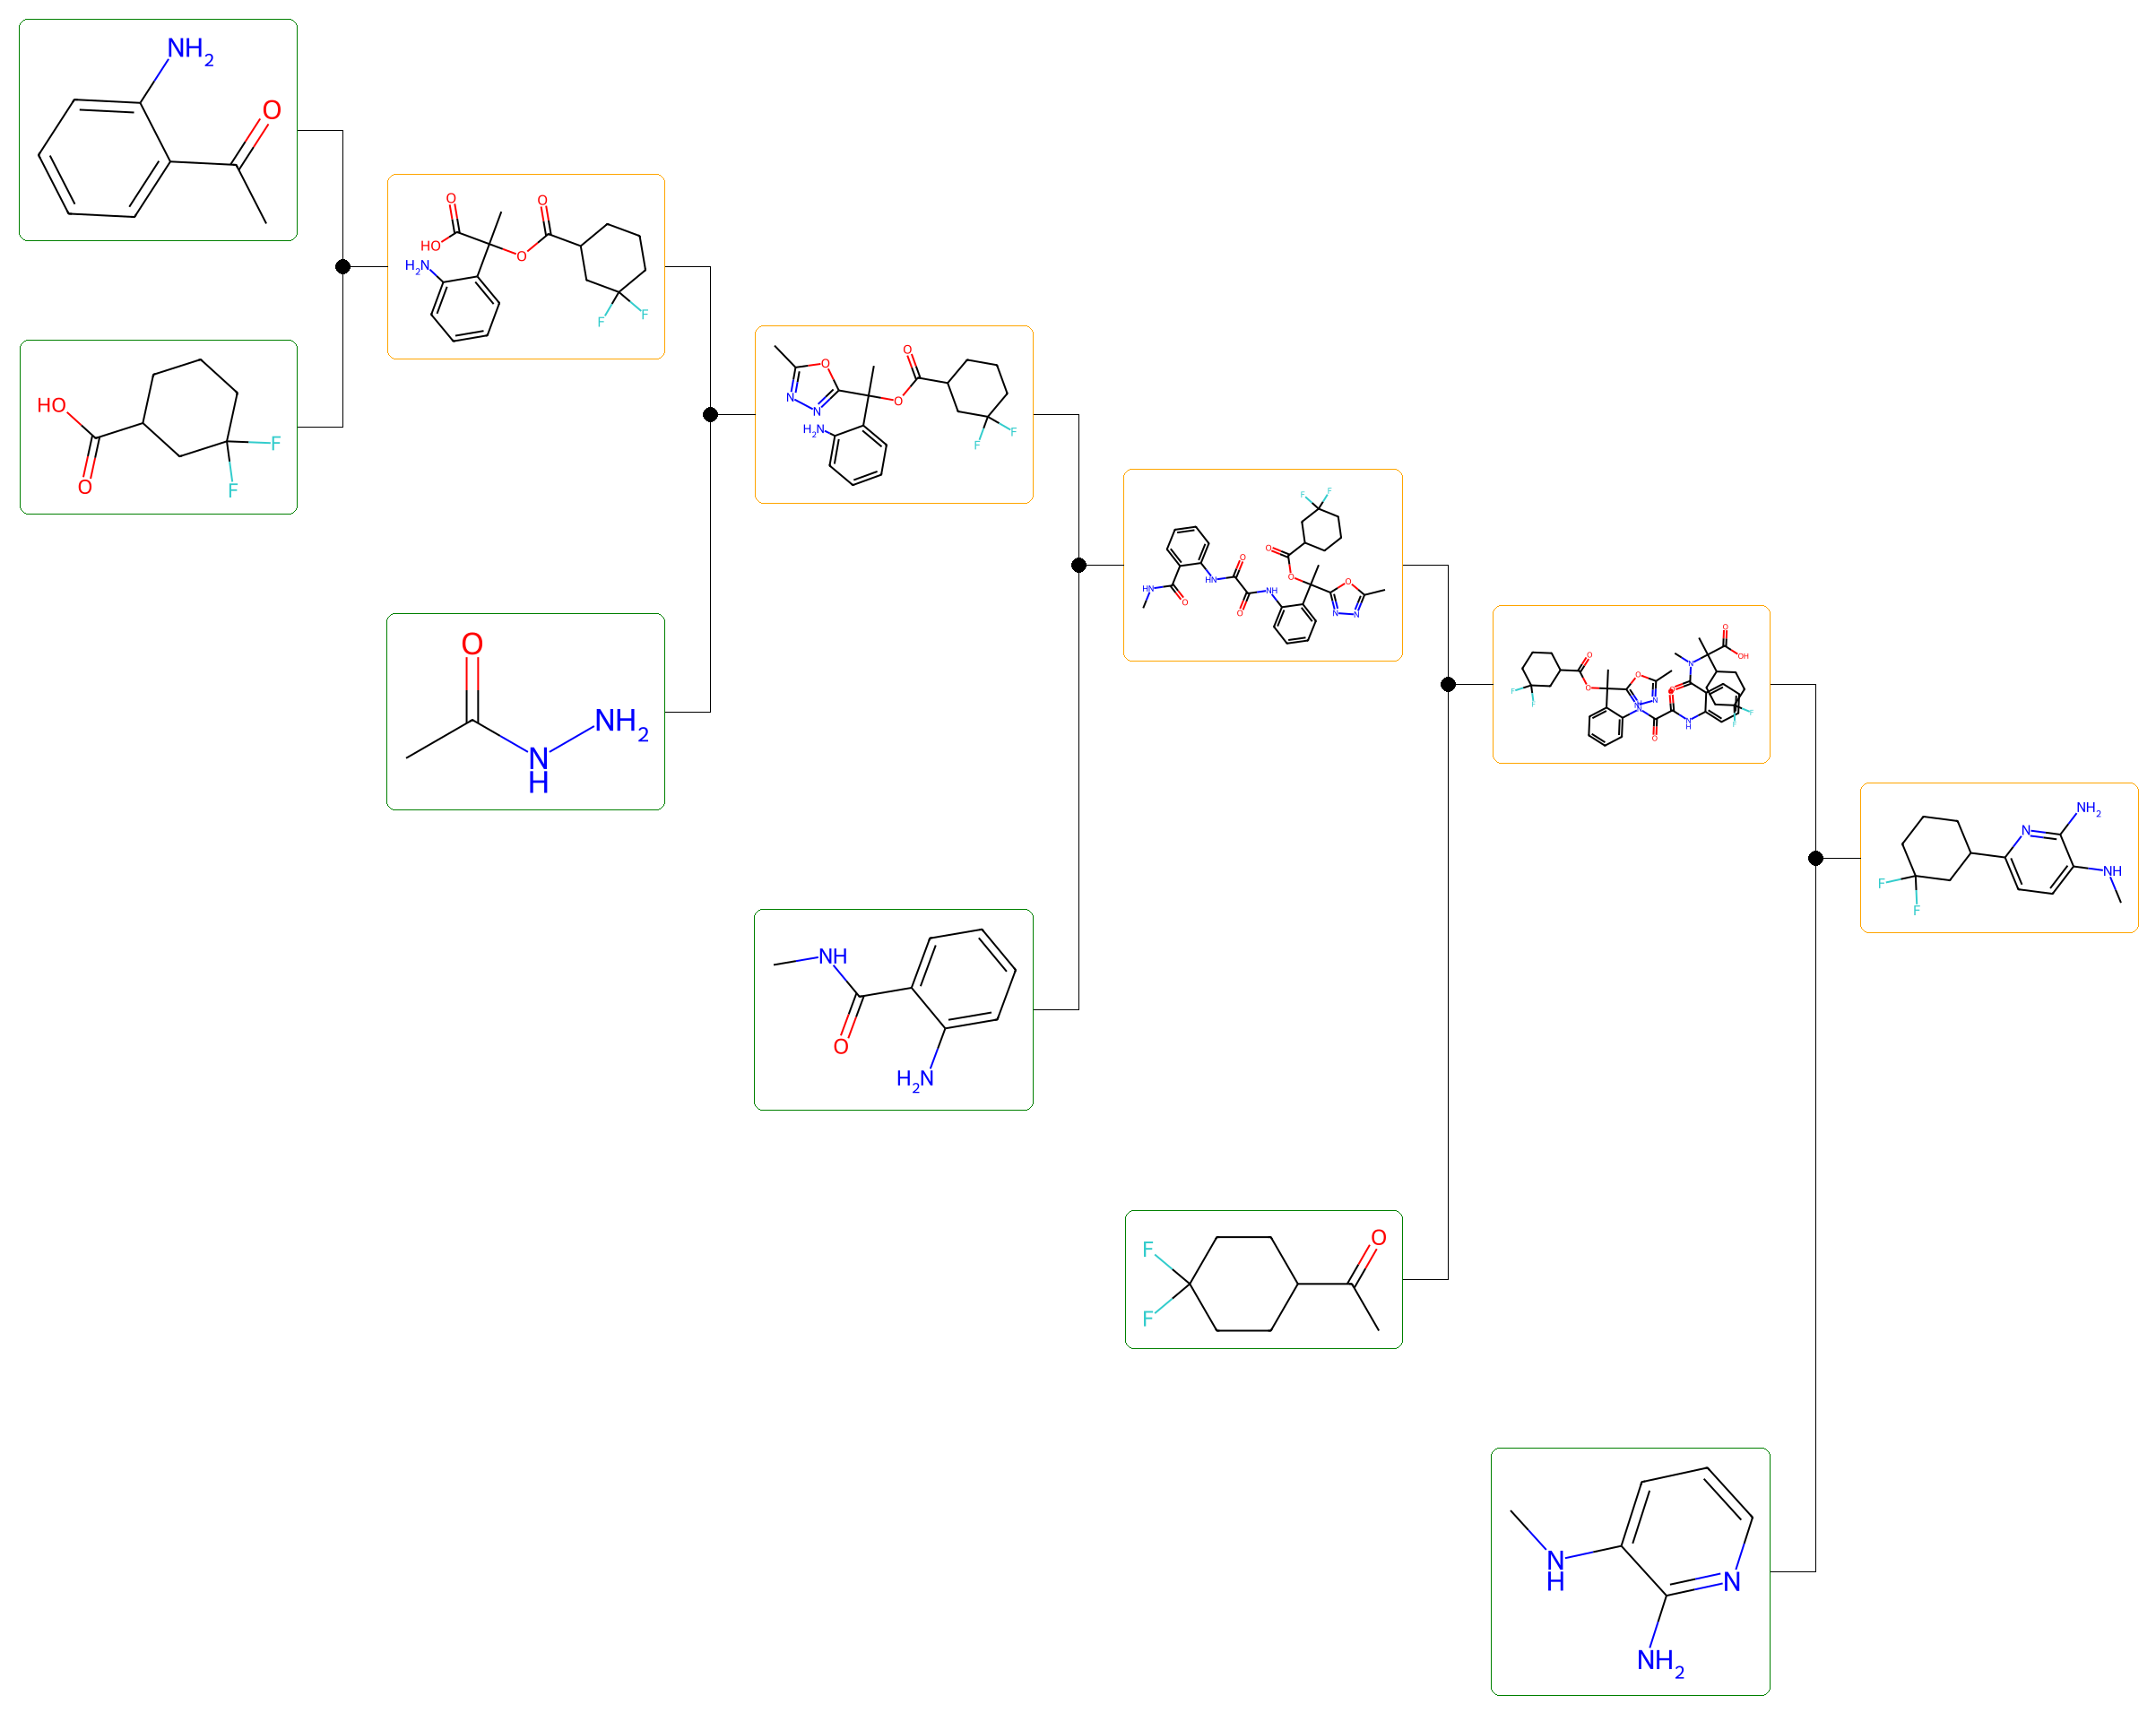

In [9]:
synthesis_str = "CC(=O)c1ccccc1N;O=C(O)C1CCCC(F)(F)C1;R71;CC(=O)NN;R51;CNC(=O)c1ccccc1N;R38;CC(=O)C1CCC(F)(F)CC1;R71;CNc1cccnc1N;R115"

route = gen_synthesis_tree(synthesis_str, matrix_reactions, novel_reactions)

factory = RouteImageFactory(route)
display(factory.image)